In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import preprocess as prep
import h5py
import numpy as np
import unicodedata
import json
import os
import pathlib
import cv2
import matplotlib.pyplot as plt
import imutils
import datetime


In [5]:
def get_dataset(type):
    """Build tf.Dataset from HDF5 file, type is 'train' or 'test' or 'validation'"""
    data_path = os.path.join('..', 'data', "{}.hdf5".format(type))
    dataset = dict()
    with h5py.File(data_path, 'r') as f:
        dataset['image'] = f['image'][:]
        dataset['label'] = f['label'][:]
        
    size = len(dataset['label'])
    dataset['label'] = [x.decode() for x in dataset['label']]
    
    return dataset, size

dataset, size = get_dataset('train')
    

OSError: Unable to open file (unable to open file: name = '../data/train.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [2]:
type_ = 'test'
DATA_FOLDER = os.path.join('..', 'data', type_)

def get_label(type_):
    labels = json.load(open(os.path.join('..', 'data', '{}.json'.format(type_))))
    return labels

labels = get_label(type_)

all_image_paths = [str(item) for item in pathlib.Path(DATA_FOLDER).glob('*') if item.name in labels]
all_image_labels = [labels[pathlib.Path(path).name] for path in all_image_paths]
print(all_image_labels[:10], all_image_paths[:10])

['2094 Quốc lộ 1A, phường Tân Chánh Hiệp, Quận 12, TP Hồ Chí Minh', 'Thôn Cầu Trong, Xã Mỹ Thái, Huyện Lạng Giang, Bắc Giang', 'Lô D4 Khu Công nghiệp Trà Đa, Xã Trà Đa, Thành Phố Pleiku, Gia Lai', 'Thôn Đông Hải, Huyện Phú Quý, Bình Thuận', 'F2/25A10 ấp 6B, Xã Vĩnh Lộc A, Huyện Bình Chánh, TP Hồ Chí Minh', 'Xóm Giữa, Xã Thanh Liệt, Huyện Thanh Trì, Hà Nội', '37/11/24 đường Phú Định, Phường 16, Quận 8, TP Hồ Chí Minh', '298 Trường Sa, Phường 02, Quận Phú Nhuận, TP Hồ Chí Minh', '14 Thanh Tịnh, Phường Vỹ Dạ, Thành Phố Huế, Thừa Thiên - Huế', 'Số 283 Đường 30/4, Phường 3, Thành phố Sóc Trăng, Sóc Trăng'] ['../data/test/0327_tests.png', '../data/test/0030_tests.png', '../data/test/0086_tests.png', '../data/test/0372_tests.png', '../data/test/0223_tests.png', '../data/test/0348_tests.png', '../data/test/0500_tests.png', '../data/test/0508_tests.png', '../data/test/0043_tests.png', '../data/test/0329_tests.png']


In [3]:
import matplotlib.pyplot as plt

def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.per_image_standardization(image)
    return image

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


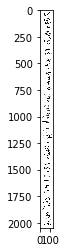

In [4]:
image = preprocess_image(all_image_paths[0])
plt.imshow(image[:,:,0], cmap='gray')

In [5]:
def get_label(type_):
    labels = json.load(open(os.path.join('..', 'data', '{}.json'.format(type_))))
    return labels
labels = get_label('train')
max([len(labels[item]) for item in labels])

69

In [6]:
# res = []
for item in labels:
    for c in labels[item]:
        if c not in res:
            res.append(c)
            
charset = ''.join(sorted(res))
print(charset, len(charset))

NameError: name 'res' is not defined

In [23]:
charset_base = "¶ #'()+,-./:0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstwuvxyzÂÊÔàáâãèéêẹìíòóôõùúýăĐđĩũƠơưạảấầẩẫậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ"
vocab_size = len(charset_base)
MAX_LABEL_LENGTH = 70
INPUT_SIZE = (128, 2048, 1)
PAD_TK = "¶"
BATCH_SIZE = 32

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [ ]:
type = 'train'
DATA_TRAIN_FOLDER = os.path.join('..', 'data', type)
train_ds = tf.data.Dataset.list_files(os.path.join(DATA_TRAIN_FOLDER, '*'))
# test_ds = tf.data.Dataset.list_files(os.path.join(DATA_TEST_FOLDER, '*','*'))

for f in train_ds.take(5):
    print(f.numpy())

def text_to_labels(text):
    return np.asarray(list(map(lambda x: charset_base.index(x), text)), dtype=np.uint8)

def labels_to_text(labels):
    return ''.join(list(map(lambda x: charset_base[x] if x < len(charset_base) else "", labels)))

def get_label(type_):
    labels = json.load(open(os.path.join('..', 'data', '{}.json'.format(type_))))
    return labels

def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)/255
    image = tf.image.per_image_standardization(image)
    return image
    

def load_and_preprocess_image(path, label):
    # label = text_to_labels(label)
    # label = pad_sequences(label, maxlen=MAX_LABEL_LENGTH, padding='post')
    return preprocess_image(path), label

def cv2_augmentation(img,
                    rotation_range=3,
                    scale_range=0,
                    height_shift_range=5,
                    width_shift_range=5,
                    dilate_range=3,
                    erode_range=3):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    img = img.numpy().astype(np.float32)
    h, w = img.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range + 10)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    img = cv2.warpAffine(img, affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
    img = cv2.erode(img, erode_kernel, iterations=1)
    img = cv2.dilate(img, dilate_kernel, iterations=1)

    return img

@tf.function
def augmentation(image, label):
    image = tf.py_function(cv2_augmentation, [image], tf.float32)
    return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=100, augment=False):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)

    if augment:
        ds.map(augmentation, num_parallel_calls=AUTOTUNE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def prepare_for_testing(ds):
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def build_dataset(type_, cache=False, augment=False, training=True):
    DATA_FOLDER = os.path.join('..', 'data', type_)
    ds = tf.data.Dataset.list_files(os.path.join(DATA_FOLDER, '*'))
    labels = get_label(type_)
    all_image_paths = [str(item) for item in pathlib.Path(DATA_FOLDER).glob('*') if item.name in labels]
    labels = [labels[pathlib.Path(path).name] for path in all_image_paths]
    all_image_labels = [text_to_labels(label) for label in labels]
    all_image_labels = pad_sequences(all_image_labels, maxlen=MAX_LABEL_LENGTH, padding='post')
    print(all_image_labels[:10])

    n_samples = len(all_image_labels)
    steps_per_epoch = tf.math.ceil(n_samples/BATCH_SIZE)

    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if training:
        ds = prepare_for_training(ds, cache=cache, shuffle_buffer_size=n_samples, augment=True)
    else:
        ds = prepare_for_testing(ds)

    return ds, steps_per_epoch, labels

# train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

# for image, label in train_ds.take(1):
#     print("Image shape: ", image.numpy().shape)
#     print("Label: ", label.numpy())

In [15]:
2560 /160

1024 / 128

8.0

(104, 1852)


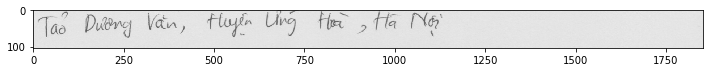

In [26]:
path = '../data/raw/0916_DataSamples_2/1455_samples.png'
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
print(image.shape)

def plot_image(image):
    plt.figure(figsize=(12,12))
    plt.imshow(imutils.opencv2matplotlib(image))
    plt.show()
    
plot_image(image)

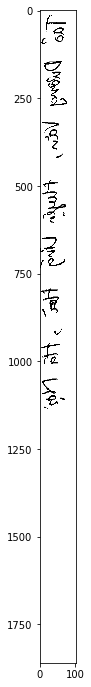

In [9]:
import preprocess as prep
import train
img_prep = prep.preprosess_raw(path, input_size=(1860, 106, 1))
plot_image(prep.adjust_to_see(img_prep))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1024 128


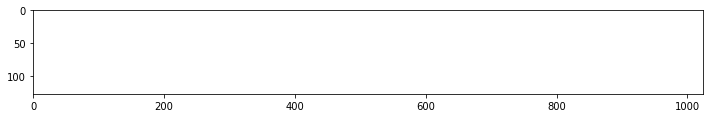

In [43]:
def cv2_augmentation(img,
                    rotation_range=3,
                    scale_range=0,
                    height_shift_range=5,
                    width_shift_range=5,
                    dilate_range=3,
                    erode_range=3):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    img = img.astype(np.float32)
    h, w = img.shape
    print(h, w)
    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range + 10)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    img = cv2.warpAffine(img, affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
    img = cv2.erode(img, erode_kernel, iterations=1)
    img = cv2.dilate(img, dilate_kernel, iterations=1)

    return img

img_aug = cv2_augmentation(img_prep)
plot_image(prep.adjust_to_see(img_aug))

In [2]:
import train
import model as mb
test_ds, num_steps_val, _ = train.build_dataset('val', training=False)

['số 5 Công Trường Mê Linh , phường Bến Nghé , quận 1', 'Số 3 Nguyễn Ngọc Vũ , Hà Nội', 'Số 30 Nguyên Hồng , Láng Hạ , Đống Đa , Hà Nội', 'Tòa nhà 34T , Hoàng Đạo Thúy , Hà Nội', 'Up coworking Space , 89 Láng Hạ , Hà Nội', 'Vĩnh Trung Plaza , B , 255 - 257 đường Hùng Vương , phường Vĩnh Trung', '168 Ngô Gia Tự , thành phố Hà Tĩnh', 'Số 370 / 8 khu phố 5B , phường Tân Biên , Biên Hòa , Đồng Nai', '96 / 7 / 12B Phạm Văn Đồng , thành phố Pleiku', '40 Cát Linh , Đống Đa , Hà Nội']
[[ 63 121   1 ...   0   0   0]
 [ 40 121   1 ...   0   0   0]
 [ 40 121   1 ...   0   0   0]
 ...
 [ 40 121   1 ...   0   0   0]
 [ 21  18   1 ...   0   0   0]
 [ 16  12   1 ...   0   0   0]]
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [17]:
checkpoint = './checkpoint_weights.hdf5'
path = '../data/val'

charset_base = "¶ #'()+,-./:0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstwuvxyzÂÊÔàáâãèéêẹìíòóôõùúýăĐđĩũƠơưạảấầẩẫậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ"
vocab_size = len(charset_base)
MAX_LABEL_LENGTH = 70
INPUT_SIZE = (2048, 128, 1)
PAD_TK = "¶"


BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

assert os.path.isfile(checkpoint) and os.path.exists(path)
type_ = pathlib.Path(path).name
ds, num_steps, labels = train.build_dataset(type_, training=False)
model = mb.build_model(input_size=INPUT_SIZE, d_model=vocab_size+1)
model.load_weights(checkpoint)
model.summary()

start_time = datetime.datetime.now()

predictions = model.predict(ds, steps=num_steps)

[[ 63 121   1  17   1  24  86  58  52   1  41  62  98 127  58  52   1  34
   80   1  33  54  58  53   7   1  60  53  98 127  58  52   1  23 112  58
    1  35  52  53  79   7   1  61  66 105  58   1  13   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 40 121   1  15   1  35  52  66  69 115  58   1  35  52 119  49   1  43
   95   7   1  29  74   1  35 125  54   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 40 121   1  15  12   1  35  52  66  69  80  58   1  29 122  58  52   7
    1  33  75  58  52   1  29  99   7   1  92 121  58  52   1  92  47   7
    1  29  74   1  35 125  54   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 41  84  47   1  58  53  74   1  15  16  41   7   1  29  59  74  58  52
    1  92  99  59   1  41  53  89  69   7   1  29  74   1  

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [128,1168,1], [batch]: [128,941,1]
	 [[node IteratorGetNext (defined at /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
	 [[IteratorGetNext/_2]]
  (1) Invalid argument:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [128,1168,1], [batch]: [128,941,1]
	 [[node IteratorGetNext (defined at /home/jupyter/.local/lib/python3.5/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_21801]

Function call stack:
distributed_function -> distributed_function


In [28]:
for image_batch, label_batch in test_ds:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [128,1168,1], [batch]: [128,941,1] [Op:IteratorGetNextSync]

In [13]:
label_batch[0]

NameError: name 'label_batch' is not defined

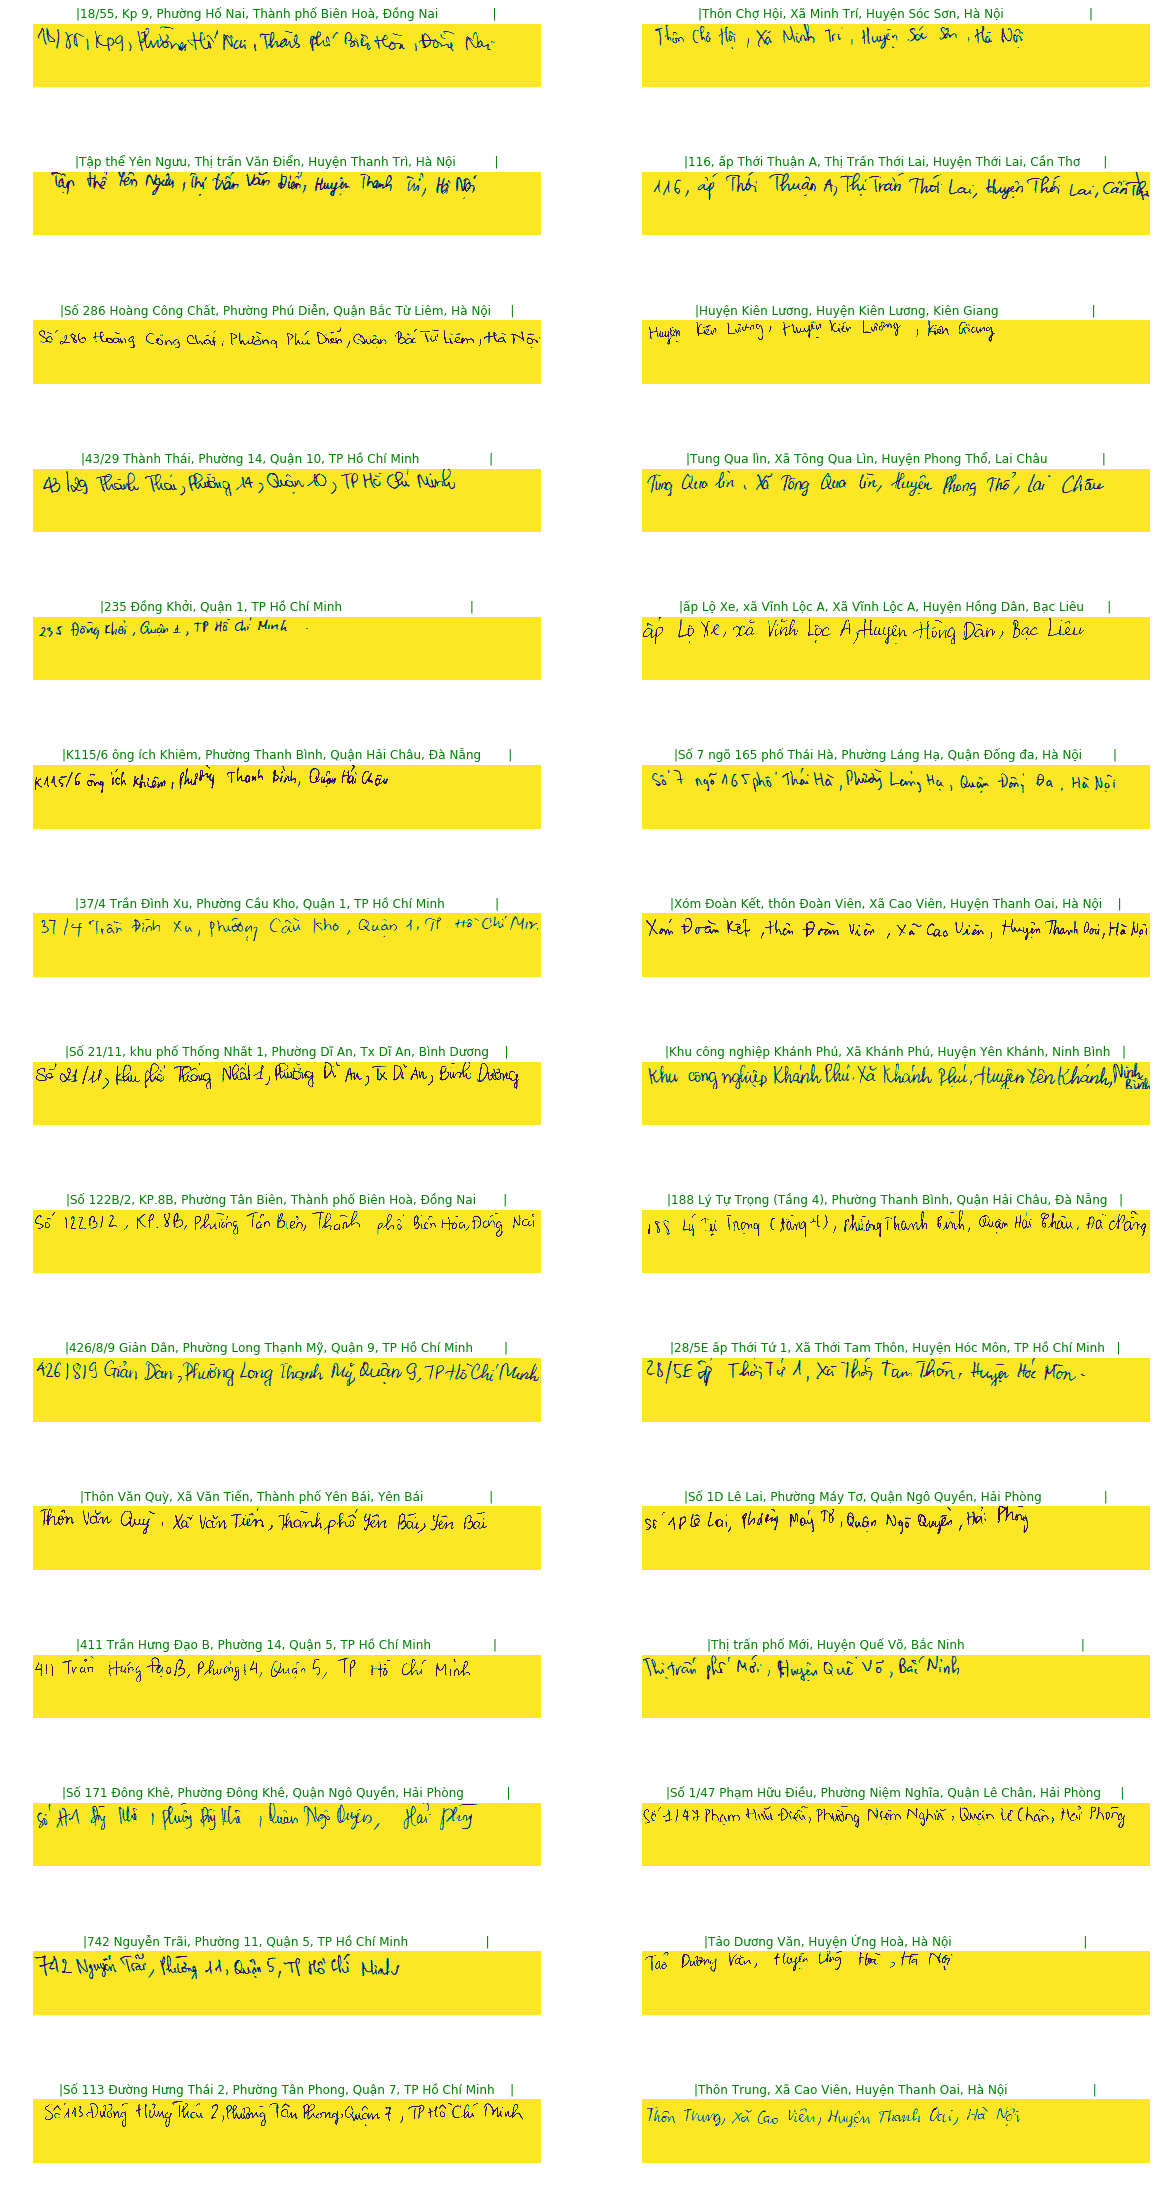

In [45]:
plt.figure(figsize=(20,40))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    image = image_batch[n][:,:,0].numpy()
    plt.subplot(15,2,n+1)
    plt.imshow(prep.adjust_to_see(image))
    color = "green"
    plt.title('|'+train.labels_to_text(label_batch[n])+'|', color=color)
    plt.axis('off')

In [7]:
0.001/2e-4

5.0

In [4]:
a=[[1, 2, 3, 0, 0]]
tf.math.count_nonzero(a, axis=-1, keepdims=True, dtype="int64")

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[3]])>

In [3]:
tf.test.is_gpu_available()

True

[]

In [1]:
import tensorflow as tf

print(tf.__version__)

2.0.0


In [2]:
# tf.config.list_physical_devices('GPU')

AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'list_physical_devices'

In [4]:
tf.constant(70, shape=(1, 1), dtype="int64")

<tf.Tensor: id=2, shape=(1, 1), dtype=int64, numpy=array([[70]])>

In [7]:
tf.math.count_nonzero([0, 1, 2], axis=-1, keepdims=True, dtype="int64")

<tf.Tensor: id=20, shape=(1,), dtype=int64, numpy=array([2])>

In [8]:
tf.constant(70, shape=(10, 1))

<tf.Tensor: id=23, shape=(10, 1), dtype=int32, numpy=
array([[70],
       [70],
       [70],
       [70],
       [70],
       [70],
       [70],
       [70],
       [70],
       [70]], dtype=int32)>